In [53]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import display
from joblib import dump, load
from keras.utils.vis_utils import plot_model
from sklearn import set_config
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, f1_score, make_scorer)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier, plot_tree

from ml_model import PipelineManager, PredictionPipeline
from utils.GPU_models import KerasClassifierModel, multi_input_embedded_model
from utils.preprocessing_utils import (clean_and_preprocess_datasets,
                                       clean_labs, clean_notas,
                                       clean_sociodemograficos,
                                       disease_tests_list, merge_classes,
                                       merge_labs_notas,
                                       word_count_feat_engineering)


In [54]:
set_config(display="diagram")
sns.set_style("darkgrid")

# Feature and data config
balance_classes = 'oversample' # False, 'oversample', or 'undersample'
retrain_with_class_weight=False
add_gpu_prediction = False
consolidate_classes = False
as_dual_class=False
target_feature = 'Código'
text_feature = 'Plan'

# Hyperparameter tuning configuration
fit_pipeline = True
cv = 5
n_iter = 16
n_jobs = -3

# Paths
cleaning_dict_path = "utils/lab_test_name_aggregation.json"
save_path = Path('data') / 'output' / 'best_model.pickle'

## Data setup

In [55]:
with open(cleaning_dict_path, "r") as in_file:
    dict_tests = json.load(in_file)

df_notas = pd.read_csv('data/notas.csv', sep=';')
df_laboratorios = pd.read_csv('data/laboratorios.csv', sep=';')
df_sociodemografico = pd.read_csv('data/sociodemografico.csv', sep=';')

In [56]:
df_notas.head()

,IDRecord,Código,Nombre,Tipo,Plan
0,44600,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...


In [57]:
df_laboratorios.head()

,IDRecord,Codigo,Nombre,Fecha,Valor
0,95627,902045,TIEMPO DE PROTROMBINA (PT),22/02/2022 18:43,NaN
1,125572,902045,TIEMPO DE PROTROMBINA (PT),17/02/2022 13:41,NaN
2,55788,902045,TIEMPO DE PROTROMBINA (PT),22/06/2021 12:50,1.05
3,113766,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 12:11,NaN
4,44596,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 13:15,NaN


In [58]:
df_sociodemografico.head()

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+
3,307,88,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,NaN
4,325,94,Hombre,Ninguno de los anteriores,Zona Rural,Viudo/a,NaN


In [59]:
df_notas.head()

,IDRecord,Código,Nombre,Tipo,Plan
0,44600,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...


## Data Cleaning

In [60]:
df_sociodemografico = clean_sociodemograficos(df_sociodemografico)
df_laboratorios = clean_labs(df_laboratorios, name_aggregation_dict=dict_tests)
df_notas = clean_notas(df_notas, apply_lemmatization=False)

### Merge the sociodemographic data with the medical notes dataset

In [61]:
df_merge = df_sociodemografico.merge(df_notas, how='inner', on='IDRecord')
df_merge

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,Plan
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,PACIENTE QUIEN CONTINUA EN PROGRAMA DE NEFROPR...
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,CONTINUA EN PROGRAMA DE CRONICOS.
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...
...,...,...,...,...,...,...,...,...,...,...,...
140167,205218,28,Hombre,Ninguno de los anteriores,Zona Urbana,NaN,NaN,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,"se explica acerca del programa, Se recomienda ..."
140168,205227,24,Hombre,Ninguno de los anteriores,Zona Urbana,Soltero,O+,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,Elaboracion duelo frente al diagnostico. Ref...
140169,205253,84,Hombre,Mestizo,Zona Urbana,Casado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,FUROATO MOMETASONA 1 SPRY NASAL POR CADA FOSA ...
140170,205577,62,Hombre,Mestizo,Zona Urbana,Desconocido,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Impresión Diagnóstica,CONTROL MEICO EN UN MES-INFECTOLOGIA VALORACI...


## Feature Engineering

In [62]:
# Merge the classes
if consolidate_classes:
    df_merge = merge_classes(df_merge)

# Perform word count feature engineering
df_merge = word_count_feat_engineering(df_merge)

# Preprocess the lab data and merge it with the sociodemographic data
df_merge = merge_labs_notas(df_laboratorios, df_merge)

with pd.option_context('display.max_columns', None):
    display(df_merge.head(5))

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,Plan,acido,antibio,asintoma,cabeza,diabet,diet,gluco,hepat,insulin,keto,penici,preservativo,rpr,sable,serolo,sifili,test_reloj_orden,vih,top_lab_code,top_lab_avg_value,top_lab_max_value,top_lab_count,total_lab_count,first_lab_date,last_lab_date,date_diff_first_last,date_diff_mean,date_diff_max,liver_damage_count,liver_damage_max,hematic_info_count,hematic_info_max,bacterias_count,bacterias_max,hormones_count,hormones_max,other_diseases_count,other_diseases_max,kidney_damage_count,kidney_damage_max,heart_damage_count,heart_damage_max,minerals_count,minerals_max,white_cells_count,white_cells_max,vih_count,vih_max,diabetes_tests_count,diabetes_tests_max,syphilis_tests_count,syphilis_tests_max
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,PACIENTE QUIEN CONTINUA EN PROGRAMA DE NEFROPR...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,902213,10.0,10.0,1.0,8.0,1.609114e+18,1.609114e+18,0.0,0.0,0.0,0.0,0.0,1.0,10.0,0.0,0.0,1.0,189.0,0.0,0.0,2.0,500.0,3.0,150.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,CONTINUA EN PROGRAMA DE CRONICOS.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Label encoding

In [63]:
X = df_merge.drop(labels=[target_feature], axis=1)
y = df_merge[target_feature]
if as_dual_class:
    y = y.str[:2]

label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y)

np.unique(y_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([  977,    94,  2614,  1970, 60586, 47408,  6278, 17437,  2808]))

## Train-test split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, train_size=0.2, random_state=42, stratify=y_labels)
np.unique(y_train, return_counts=True) # Let's check the number of samples per label

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([  195,    19,   523,   394, 12117,  9481,  1256,  3487,   562]))

## Class Balancing

In [65]:
if balance_classes == 'oversample':
    # Using a naive oversampling approach
    sampler = RandomOverSampler(random_state=42)
    X_train, y_train = sampler.fit_resample(X_train, y_train)
elif balance_classes == 'undersample':
    # Using a naive oversampling approach
    sampler = RandomUnderSampler(random_state=42)
    X_train, y_train = sampler.fit_resample(X_train, y_train)
np.unique(y_train, return_counts=True) # Let's check the number of samples per label

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([12117, 12117, 12117, 12117, 12117, 12117, 12117, 12117, 12117]))

## Hyperparameter Setup

In [66]:
# Select the numerical features that will be used in the model
numerical_features = list(
    set(
        [
            "Edad",
            "top_lab_avg_value",
            "top_lab_max_value",
            "top_lab_count",
            "total_lab_count",
            "date_diff_mean",
            "date_diff_max",
            "first_lab_date",	
            "last_lab_date",
            "date_diff_first_last",
        ]
        + list(df_merge.drop(columns="IDRecord").select_dtypes(include="int64").columns)
        + [f'{test[1]}_count' for test in disease_tests_list()]
        + [f'{test[1]}_max' for test in disease_tests_list()]
    )
)

# Now select the categorical features
categorical_features = [
    "Genero",
    "GrupoEtnico",
    # "AreaResidencial",
    "EstadoCivil",
    # "TSangre",
    # "Tipo",
    "top_lab_code",
]

In [67]:
pipeline = PipelineManager(estimator="classifier")
pipeline.set_numerical_features(numerical_features)
pipeline.set_categorical_features(categorical_features)
# pipeline.set_text_feature(text_feature)
pipeline.set_basic_pipeline()

param_grid = {
    "n_estimators": np.linspace(10, 100, 10, dtype=int),
    "max_depth": list(np.linspace(2, 15, 5, dtype=int)),
    "eta": np.linspace(0.01, 0.5, 10, dtype=float),
    "min_child_weight": np.linspace(0.5, 20, 5, dtype=float),
    "gamma": np.linspace(0, 1, 5, dtype=float),
    "subsample": np.linspace(0.1, 1, 5, dtype=float),
    "colsample_bytree": np.linspace(0.2, 1, 5, dtype=float),
    "reg_lambda": np.linspace(0, 10, 5, dtype=float),
    "reg_alpha": np.linspace(0, 10, 5, dtype=float),
    # "scale_pos_weight": np.linspace(0.1, 500, 100, dtype=float),
}
estimator = XGBClassifier()
pipeline.add_estimator(estimator, param_grid)

param_grid = {
    "C": np.linspace(0, 5, 20, dtype=float),
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["auto", "scale"],
    "class_weight": ["balanced", None],
    "coef0": np.linspace(0, 5, 20, dtype=float),
    "degree": np.linspace(1, 5, 10, dtype=int),
}

pipeline.pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'EstadoCivil',
                                                   'top_lab_code']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScal...
                                                   'diabetes_tests_max',
                                                   'top_lab_max_value',
                                                   'serolo', 'date_diff_mean',
                                                   'minerals_max',
                                                   'top_lab_count', 'hepat',
                                                   'liver_damage_count', 'diet',
                                                   'minerals_count', 'keto',
                                                   'date_diff_first_last',
                                                   'top_lab_avg_value',
                                                   'bacterias_max',
                                                   'kidney_damage_max', ...])])),
                ('feature_selector',
                 SelectFromModel(estimator=RandomForestRegressor())),
                ('estimator', RandomForestClassifier())])

## Hyperparameter tuning

In [68]:
scoring = {
    "Accuracy": "balanced_accuracy",
    "Weighted_F1": make_scorer(f1_score, average='weighted'),
    # 'roc_auc':make_scorer(roc_auc_score, average='weighted'),
    }
if not fit_pipeline and not save_path.is_file():
    print(f'Could not find saved model in {save_path.resolve()}, retraining pipeline')
    fit_pipeline = True

if fit_pipeline:
    best_model = pipeline.find_best_model(
        X_train,
        y_train,
        cv=cv,
        n_iter=n_iter,
        n_jobs=n_jobs,
        scoring=scoring,
        random_state=7,
        refit='Weighted_F1',
        verbose = 8,
        # error_score='raise',
        )
    with pd.option_context('display.max_columns', None):
        display(pipeline.cv_results.sort_values(by=["rank_test_Weighted_F1"]).head(30))
else:
    best_model = load(save_path)

preprocessor = best_model.named_steps['preprocessor']
preprocessor

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__numerical__scaler,param_preprocessor__numerical__imputer,param_preprocessor__categorical__imputer,param_feature_selector,param_estimator__subsample,param_estimator__reg_lambda,param_estimator__reg_alpha,param_estimator__n_estimators,param_estimator__min_child_weight,param_estimator__max_depth,param_estimator__gamma,param_estimator__eta,param_estimator__colsample_bytree,param_estimator,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_test_Weighted_F1,split1_test_Weighted_F1,split2_test_Weighted_F1,split3_test_Weighted_F1,split4_test_Weighted_F1,mean_test_Weighted_F1,std_test_Weighted_F1,rank_test_Weighted_F1
1,159.747572,8.792590,1.245168,0.158067,RobustScaler(),SimpleImputer(strategy='most_frequent'),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Ridge()),0.775,5.0,7.5,70,5.375,11,0.0,0.391111,0.4,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__numerical__scaler': RobustScal...,0.874477,0.871988,0.864694,0.878678,0.876708,0.873309,0.004852,1,0.872162,0.869601,0.861952,0.876396,0.874666,0.870955,0.005054,1
0,4995.330474,95.143493,1001.971094,9.675214,Normalizer(),KNNImputer(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=ElasticNet()),0.1,0.0,7.5,40,10.25,8,0.75,0.173333,1.0,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__numerical__scaler': Normalizer...,0.843945,0.848468,0.845071,0.839752,0.848006,0.845048,0.003153,2,0.840579,0.845281,0.841979,0.836052,0.845293,0.841837,0.003431,2


ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Genero', 'GrupoEtnico', 'EstadoCivil',
                                  'top_lab_code']),
                                ('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('scaler', RobustScaler())]),
                                 ['cabeza', 'diabet'...
                                  'date_diff_max', 'first_lab_date',
                                  'test_reloj_orden', 'total_lab_count',
                                  'heart_damage_max', 'hematic_info_count',
                                  'bacterias_count', 'diabetes_tests_max',
                                  'top_lab_max_value', 'serolo',
                                  'date_diff_mean', 'minerals_max',
                                  'top_lab_count', 'hepat',
                                  'liver_damage_count', 'diet',
                                  'minerals_count', 'keto',
                                  'date_diff_first_last', 'top_lab_avg_value',
                                  'bacterias_max', 'kidney_damage_max', ...])])

In [69]:
dump(pipeline, str(save_path.parent / f'gpu_pipeline{save_path.suffix}'))

['data/output/gpu_pipeline.pickle']

In [72]:
X_train_preprocessed = pd.DataFrame(preprocessor.transform(X_train), columns=list(preprocessor.get_feature_names_out()))
X_test_preprocessed = pd.DataFrame(preprocessor.transform(X_test), columns=list(preprocessor.get_feature_names_out()))

,categorical__Genero_Hombre,categorical__Genero_Mujer,categorical__GrupoEtnico_Blanco,categorical__GrupoEtnico_Indígena,categorical__GrupoEtnico_Mestizo,"categorical__GrupoEtnico_Negro, Mulato, Afrocolombiano o Afro descendiente",categorical__GrupoEtnico_Ninguno de los anteriores,categorical__GrupoEtnico_Palenquero de San Basilio,categorical__EstadoCivil_Casado,categorical__EstadoCivil_Desconocido,...,numerical__rpr,numerical__other_diseases_count,numerical__diabetes_tests_count,numerical__gluco,numerical__heart_damage_count,numerical__vih_count,numerical__Edad,numerical__other_diseases_max,numerical__last_lab_date,numerical__antibio
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.333333,1.0,-0.137931,0.0,-1.308540,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.0,0.103448,0.0,-0.319559,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.111111,3.0,-0.448276,0.0,0.179063,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,-1.0,0.0,-0.444444,0.0,-0.517241,0.0,0.258343,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.888889,1.0,0.206897,0.0,0.280992,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109048,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.222222,0.0,0.000000,0.0,0.504132,0.0
109049,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-0.111111,2.0,1.068966,0.0,0.685950,0.0
109050,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,-1.0,0.0,-0.222222,1.0,0.275862,0.0,0.376245,0.0
109051,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.444444,0.0,1.448276,0.0,0.000000,0.0


In [75]:
# embedding = "nnlm-es-dim128"
embedding = "nnlm-es-dim128-with-normalization"
# embedding = "https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_L-24_H-1024_A-16/1"


model_function = multi_input_embedded_model
clf = KerasClassifierModel(
    build_fn=model_function,
    class_number=len(np.unique(y_train)),
    feature_number=len(X_train_preprocessed.columns),
    embedding = embedding,
    activation='relu',
    epochs=1000,
    batch_size=200,
    verbose=10,
)
model = model_function(
    class_number=len(np.unique(y_train)),
    feature_number=len(X_train_preprocessed.columns),
    embedding = embedding,
    ).summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 143)]        0           []                               
                                                                                                  
 Input (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 dense_16 (Dense)               (None, 128)          18432       ['input_3[0][0]']                
                                                                                                  
 keras_layer_2 (KerasLayer)     (None, 128)          125009920   ['Input[0][0]']                  
                                                                                            

Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005.
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Restoring model weights from the end of the best epoch: 1.
Epoch 61: early stopping


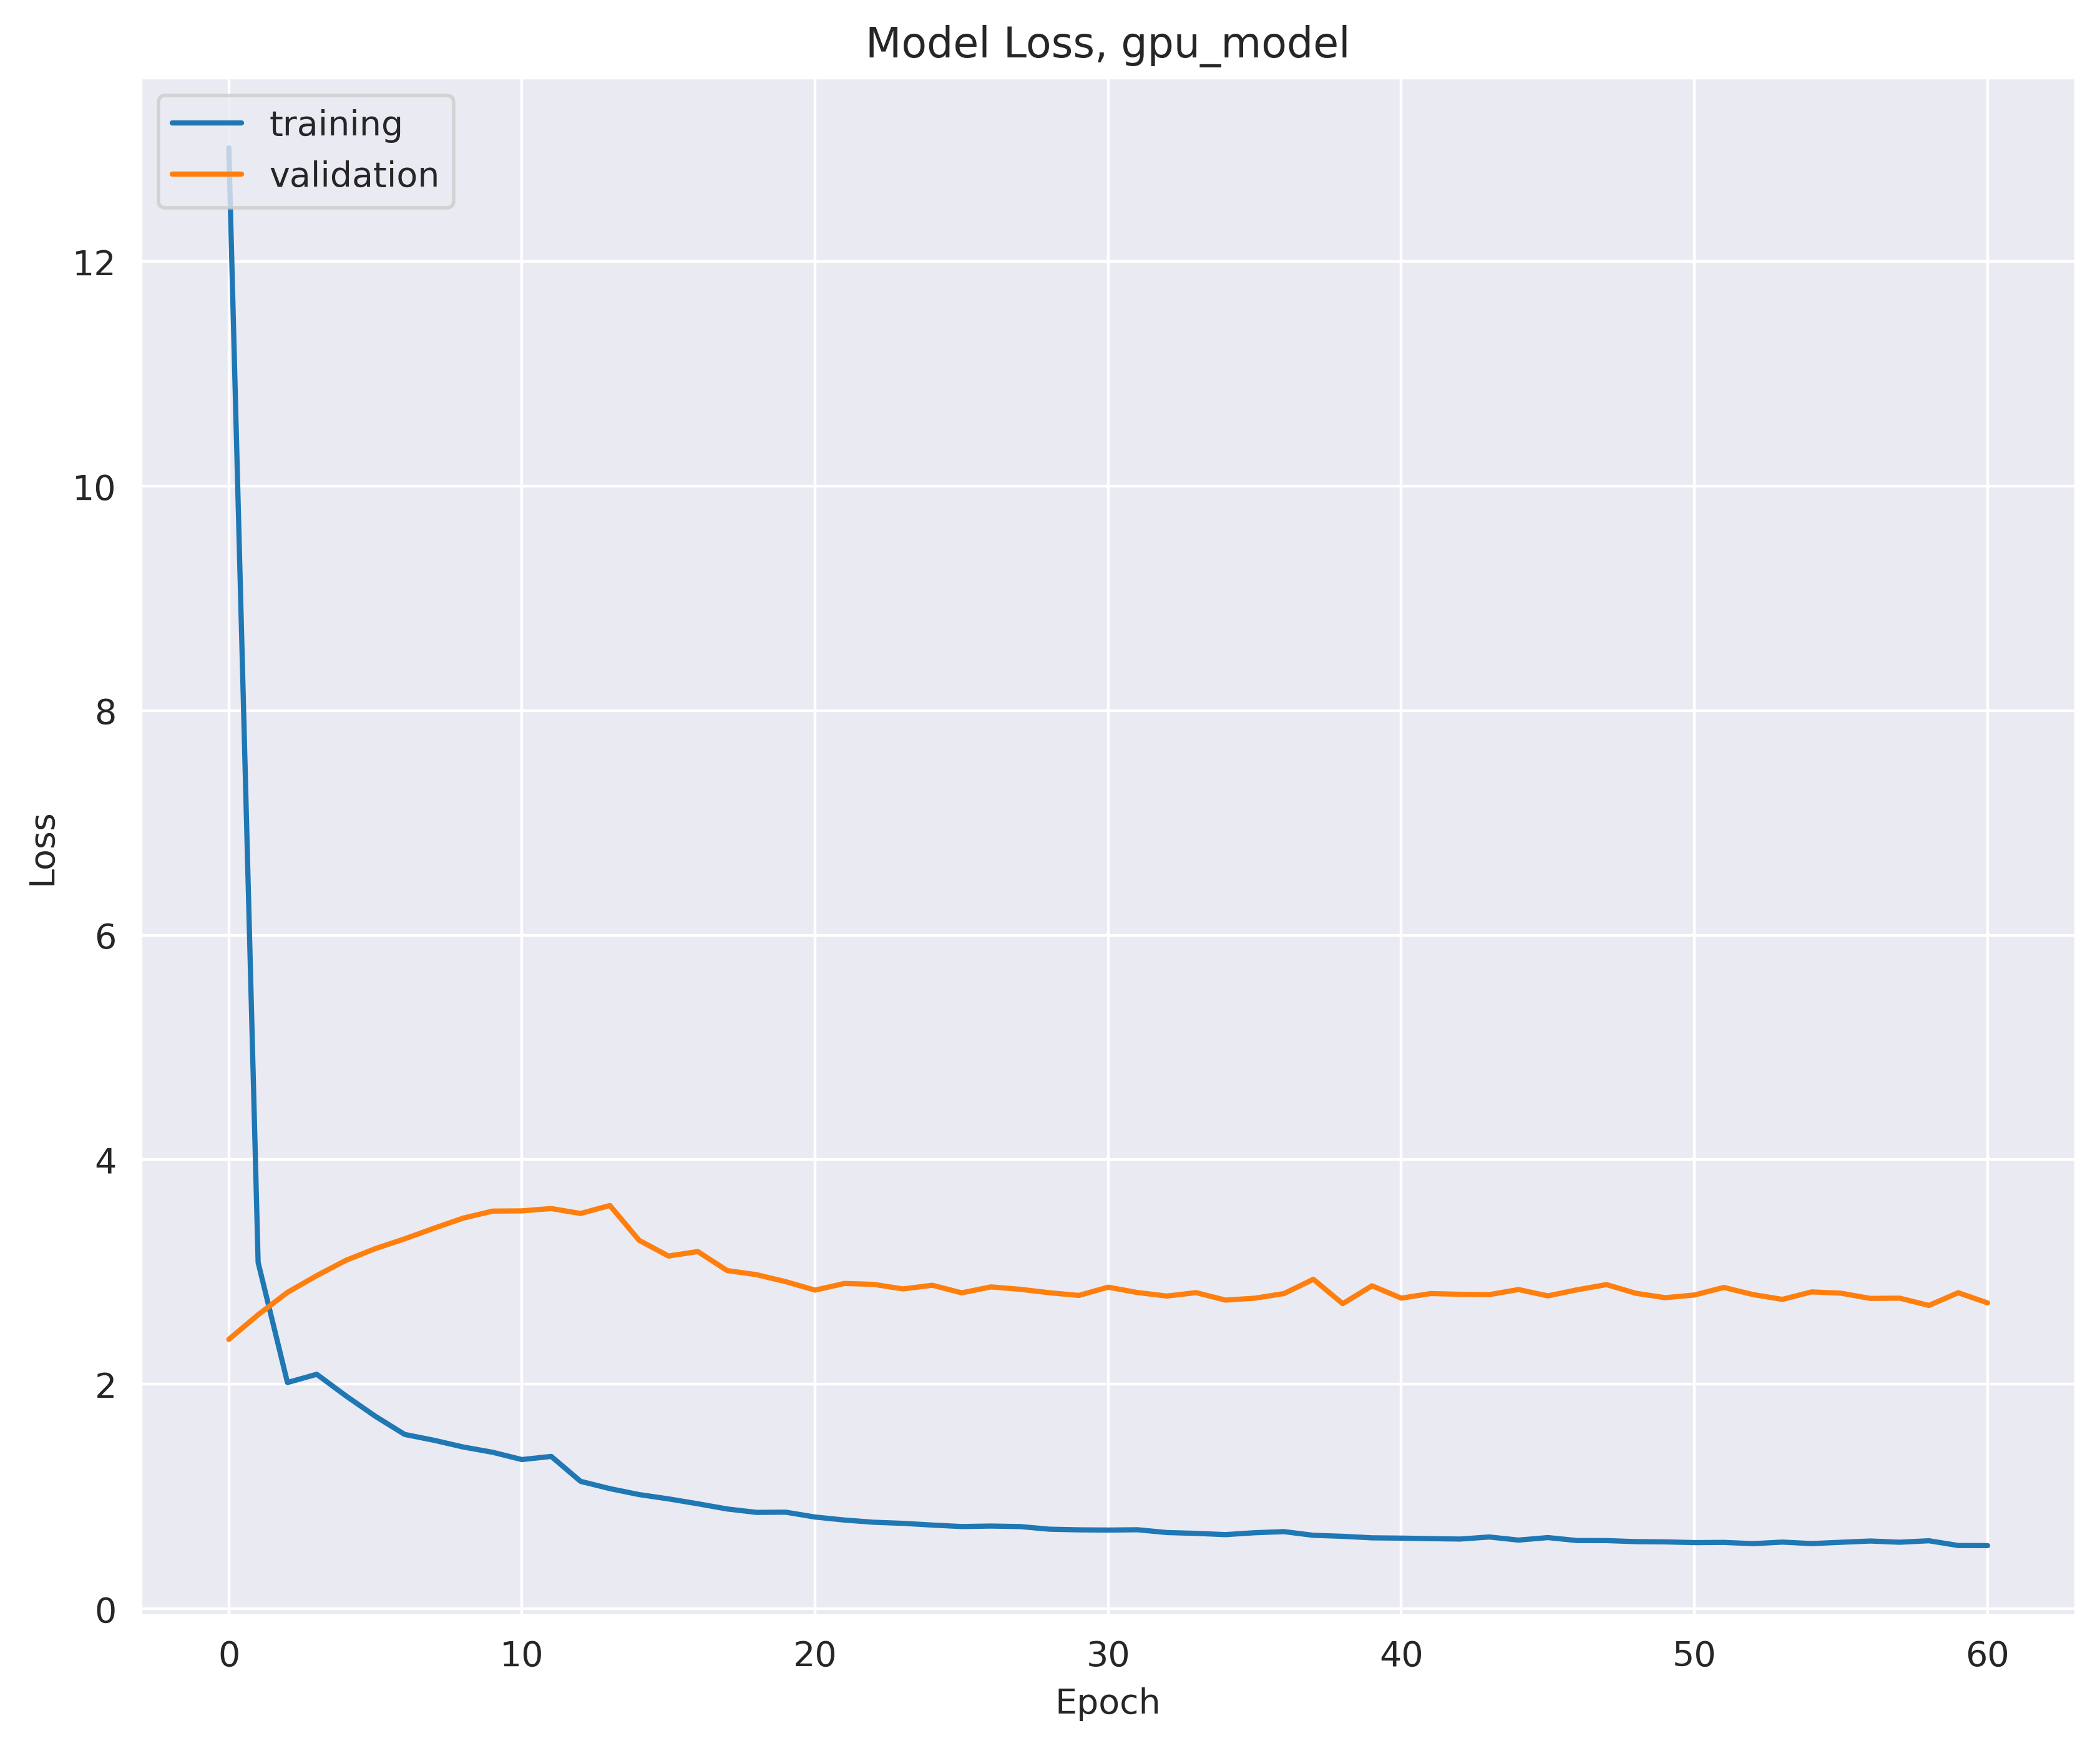

<Figure size 640x480 with 0 Axes>

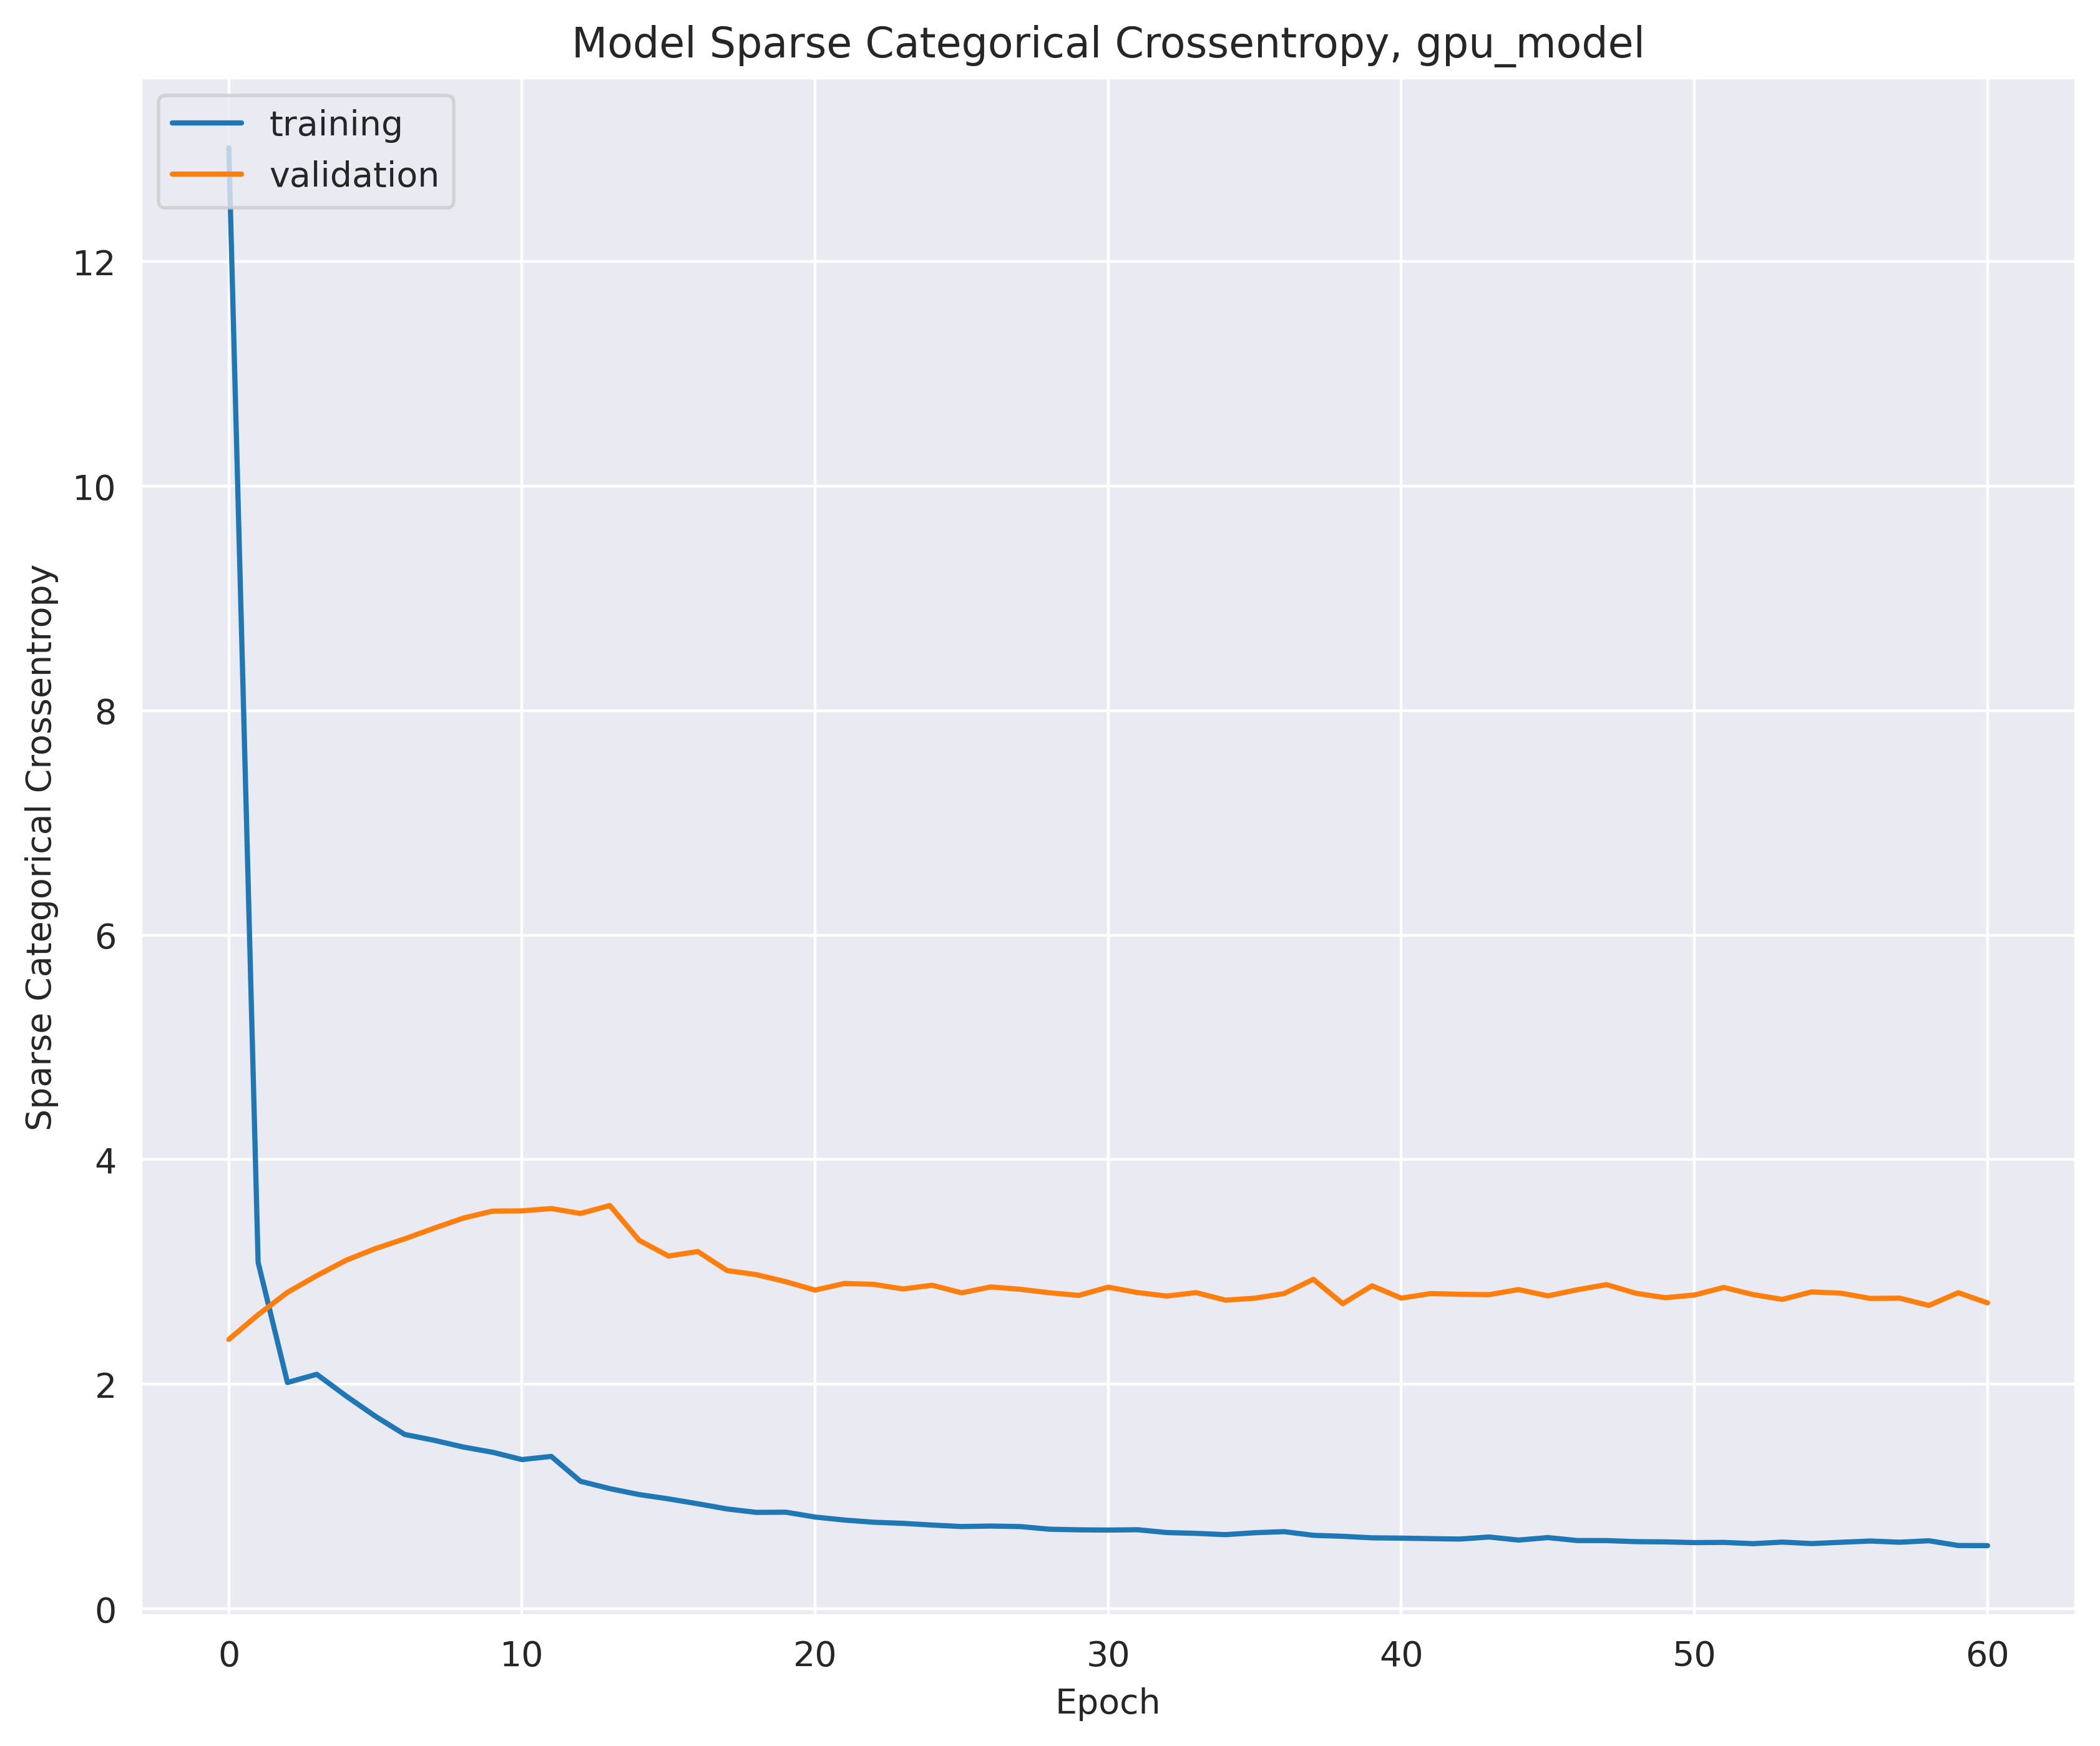

<Figure size 640x480 with 0 Axes>

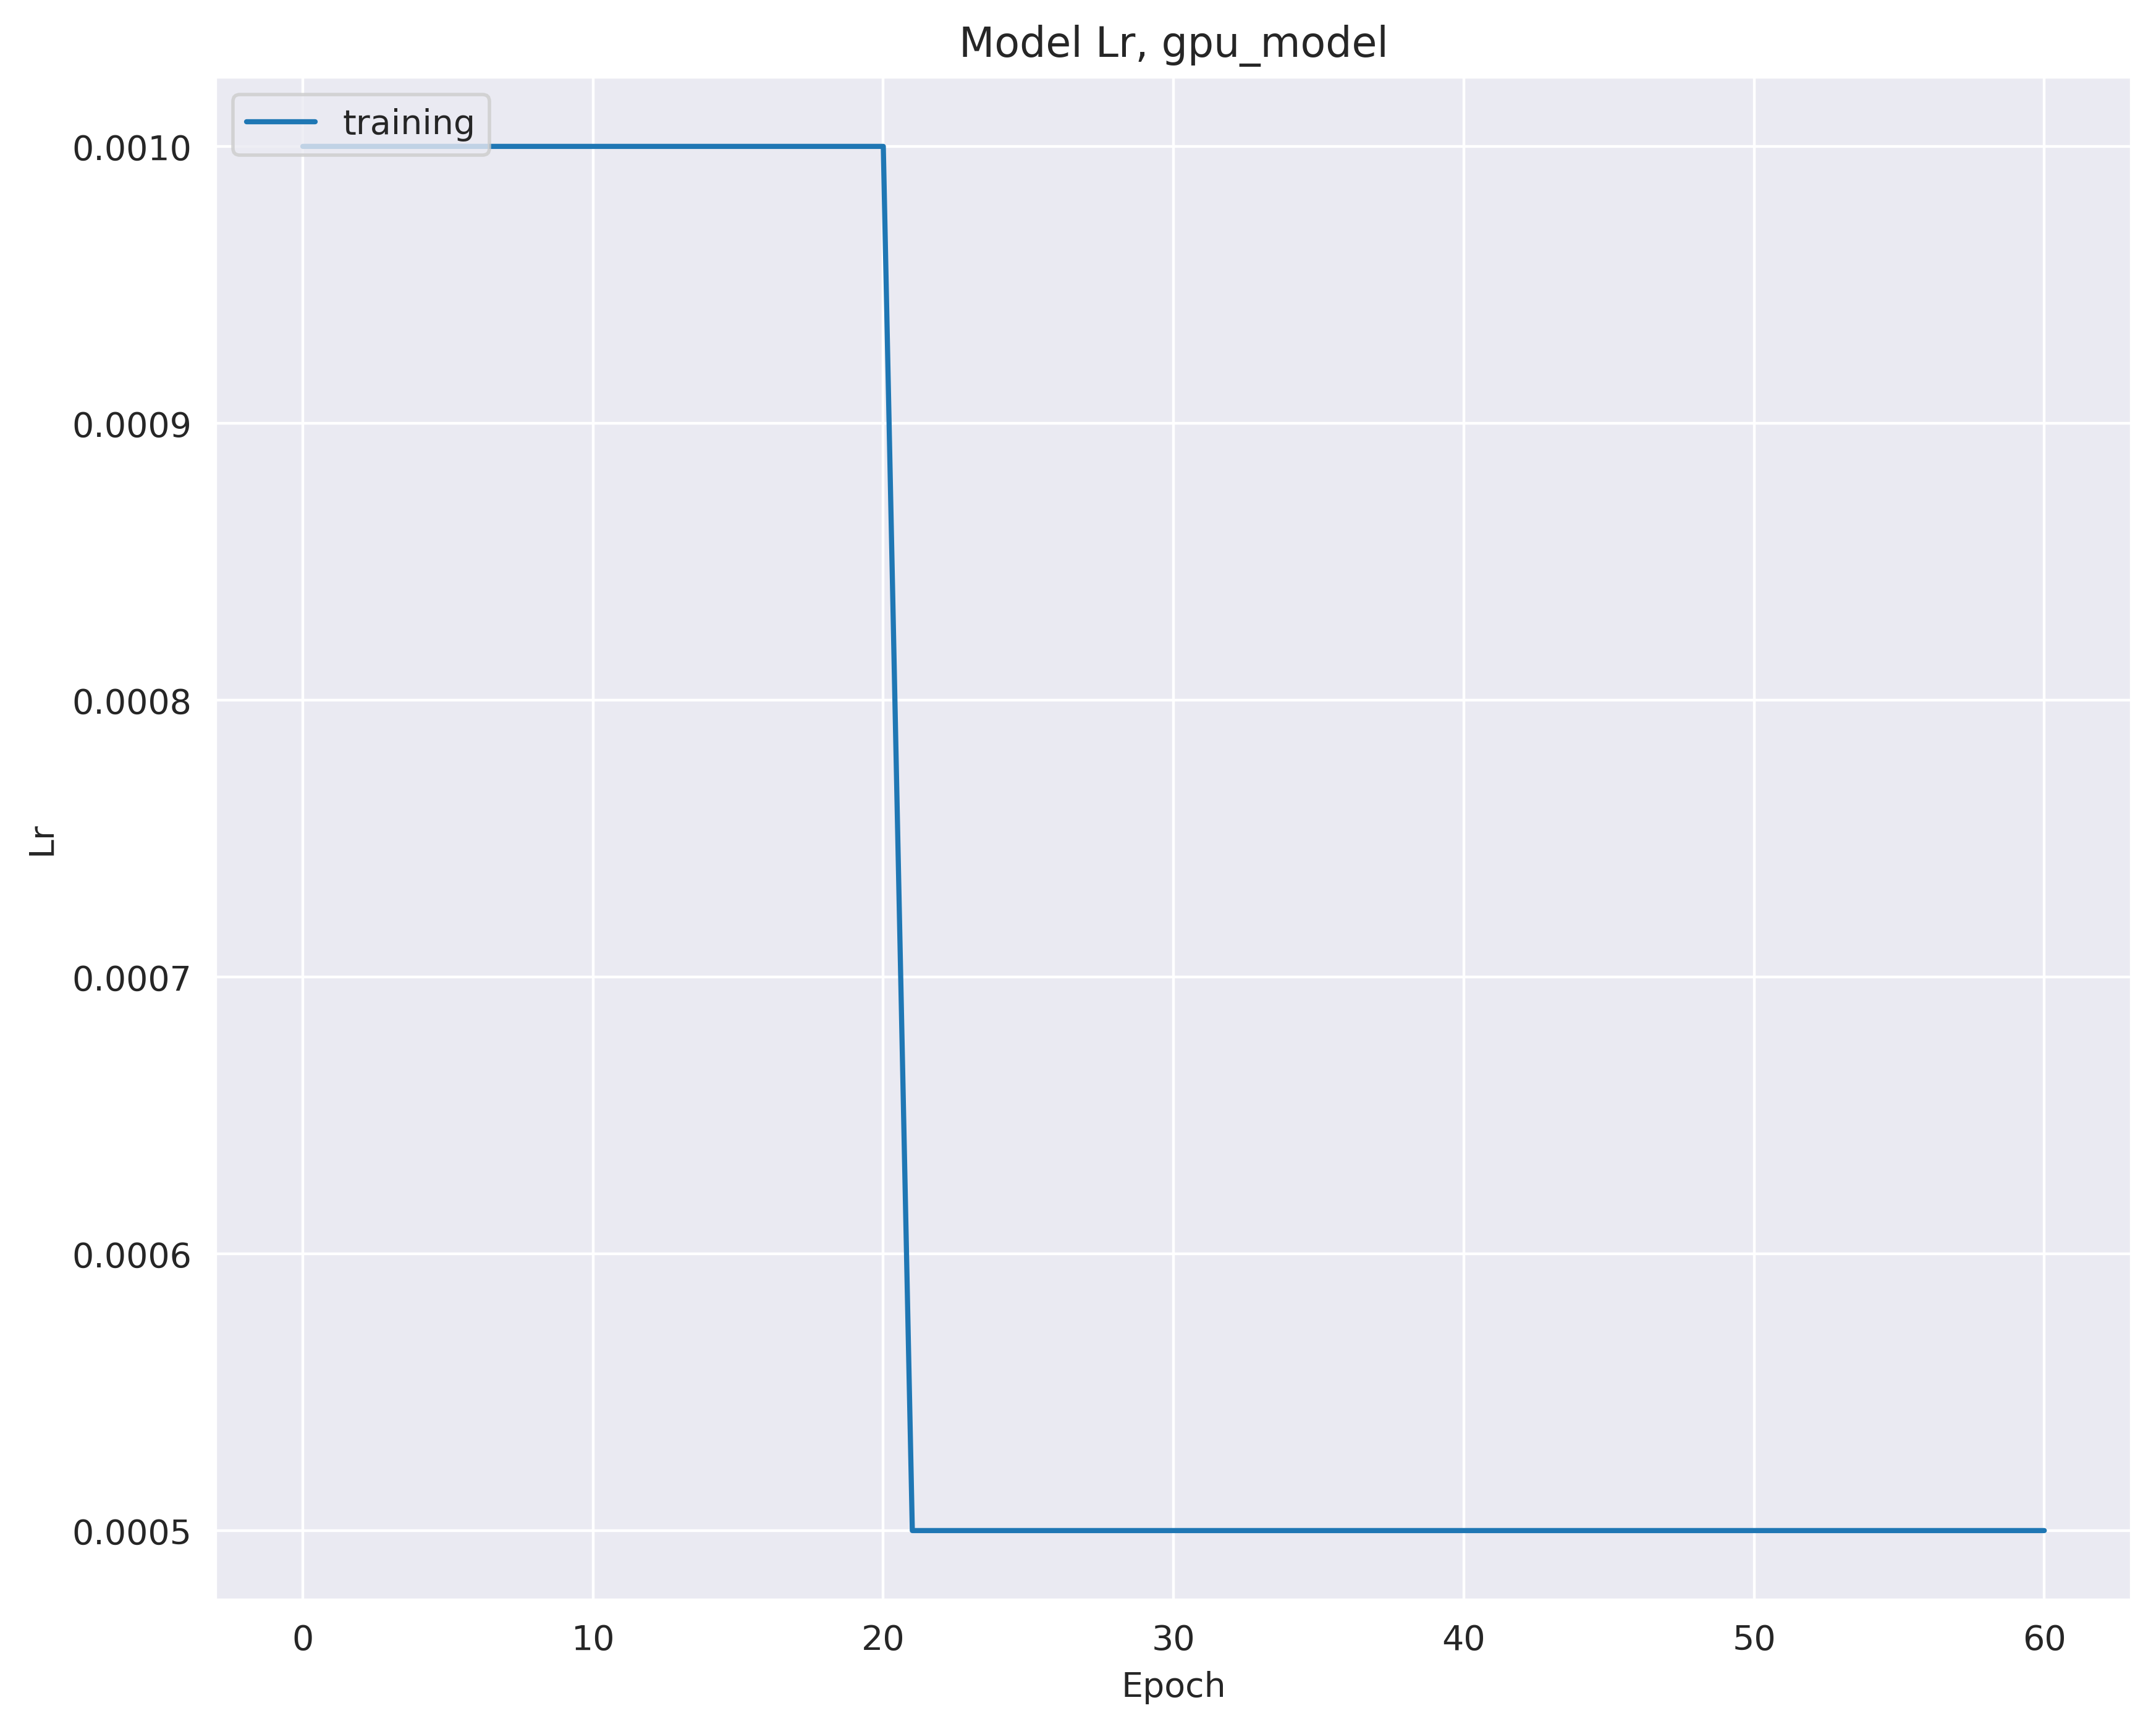

In [76]:
hist = clf.fit([X_train_preprocessed, X_train[text_feature]], y_train)
clf.plot_learning_curves('data/output/gpu_model')

In [79]:
model_plot_savepath = Path('data') / 'output' / 'gpu_model' / 'model_plot.png'
model_plot_savepath.parent.mkdir(parents=True, exist_ok=True)
plot_model(clf.model, to_file=str(model_plot_savepath), show_shapes=True, show_layer_names=True)
# clf.model

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Scoring

In [80]:
labels_decoded = label_encoder.inverse_transform(np.unique(y_train))
y_pred = clf.predict([X_test_preprocessed, X_test[text_feature]])

3505/3505 [==============================] - 34s 10ms/step


In [81]:
class_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, labels=np.unique(y_train), target_names=labels_decoded, zero_division=False)).transpose().round(2)
class_report

,precision,recall,f1-score,support
A510,0.00,0.00,0.00,782.00
A511,0.02,0.95,0.03,75.00
A514,0.05,0.09,0.06,2091.00
A529,0.02,0.05,0.03,1576.00
A530,0.50,0.03,0.06,48469.00
A539,0.35,0.86,0.49,37927.00
E109,0.18,0.07,0.10,5022.00
E119,0.00,0.00,0.00,13950.00
E149,0.00,0.00,0.00,2246.00
accuracy,0.31,0.31,0.31,0.31


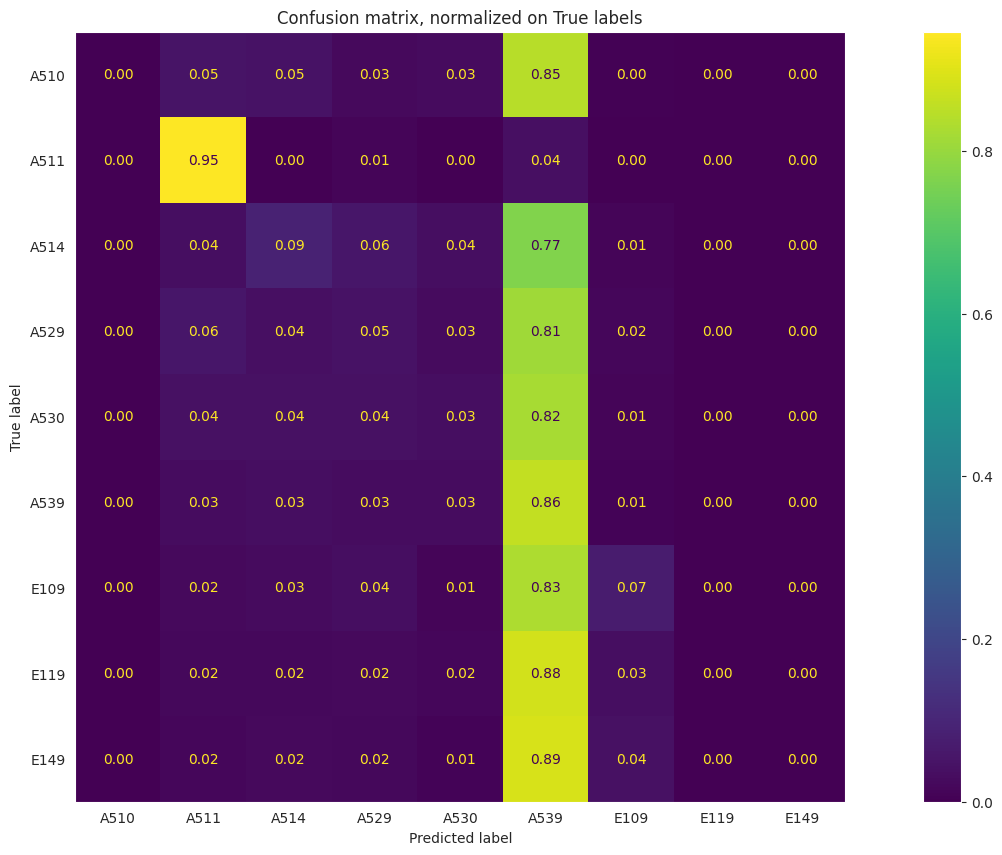

In [85]:
labels_decoded = label_encoder.inverse_transform(best_model['estimator'].classes_)

with sns.axes_style("dark"):
    fig, ax = plt.subplots(figsize=(20,10))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=labels_decoded,
        normalize='true',
        ax=ax, cmap='viridis',
        values_format=".2f")
    _ = ax.set_title('Confusion matrix, normalized on True labels')
    plt.show()

In [ ]:
score = {'confusion_matrix':test_confusion_matrix, 'classification_report':class_report}

## Saving the best performing model

In [ ]:
save_path = Path('data') / 'output' / 'best_model_gpu.pickle'
save_path.parent.mkdir(parents=True, exist_ok=True)
dump(best_model, str(save_path))
dump(score, str(save_path.parent / f'best_model_gpu_score{save_path.suffix}'))